# Predicting Heart Disease

## Score: .95374

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost as cb
from catboost import CatBoostClassifier
#%pip install torch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

DATA_DIR = Path("playground-series-s6e2")
OUTPUT_DIR = Path(".")
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [2]:
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")
train.head()

Train: (630000, 15)
Test: (270000, 14)


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [3]:
target_col = "Heart Disease"
id_col = "id"
feature_cols = [c for c in train.columns if c not in (id_col, target_col)]

le = LabelEncoder()
y = le.fit_transform(train[target_col])

X_train = train[feature_cols].copy()
X_test = test[feature_cols].copy()

for col in feature_cols:
    if X_train[col].isna().any() or X_test[col].isna().any():
        med = X_train[col].median()
        X_train[col] = X_train[col].fillna(med)
        X_test[col] = X_test[col].fillna(med)

X_train["chol_exercise"] = X_train["Cholesterol"] * X_train["Exercise angina"]
X_test["chol_exercise"] = X_test["Cholesterol"] * X_test["Exercise angina"]
X_train["st_slope"] = X_train["ST depression"] * X_train["Slope of ST"]
X_test["st_slope"] = X_test["ST depression"] * X_test["Slope of ST"]
X_train["hr_age"] = X_train["Max HR"] * X_train["Age"]
X_test["hr_age"] = X_test["Max HR"] * X_test["Age"]
X_train["bp_age"] = X_train["BP"] * X_train["Age"]
X_test["bp_age"] = X_test["BP"] * X_test["Age"]

te_cols = ["Chest pain type", "Slope of ST", "Thallium"]
global_mean = float(y.mean())
m = 20
for col in te_cols:
    agg = pd.DataFrame({"_y": y}).groupby(X_train[col])["_y"].agg(["mean", "count"])
    smoothed = (agg["count"] * agg["mean"] + m * global_mean) / (agg["count"] + m)
    X_train[col + "_te"] = X_train[col].map(smoothed).fillna(global_mean)
    X_test[col + "_te"] = X_test[col].map(smoothed).fillna(global_mean)

scaler_feat = StandardScaler()
X_tr_s = scaler_feat.fit_transform(X_train)
X_te_s = scaler_feat.transform(X_test)
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
kmeans.fit(X_tr_s)
for i in range(kmeans.n_clusters):
    d_tr = np.linalg.norm(X_tr_s - kmeans.cluster_centers_[i], axis=1)
    d_te = np.linalg.norm(X_te_s - kmeans.cluster_centers_[i], axis=1)
    X_train[f"dist_c{i}"] = d_tr
    X_test[f"dist_c{i}"] = d_te

print(f"Features: {len(X_train.columns)} columns")
print(f"Target distribution: {pd.Series(y).value_counts().to_dict()}")

c:\Users\ol1v3_7dwns5u\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ol1v3_7dwns5u\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\ol1v3_7dwns5u\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ol1v3_7dwns5u\AppData\Local\Programs\Python\Python3

Features: 32 columns
Target distribution: {0: 347546, 1: 282454}


In [4]:
param_grid = {"depth": [4, 5, 6], "lr": [0.03, 0.04, 0.05], "min_data_in_leaf": [15, 25, 35]}
n_est = 800
best_auc, best_params = 0, None
for depth in param_grid["depth"]:
    for lr in param_grid["lr"]:
        for min_leaf in param_grid["min_data_in_leaf"]:
            m = cb.CatBoostClassifier(iterations=n_est, depth=depth, learning_rate=lr, min_data_in_leaf=min_leaf, subsample=0.75, colsample_bylevel=0.75, random_seed=42, verbose=0)
            oof = cross_val_predict(m, X_train, y, cv=cv, method="predict_proba")[:, 1]
            auc = roc_auc_score(y, oof)
            if auc > best_auc:
                best_auc, best_params = auc, {"depth": depth, "lr": lr, "min_data_in_leaf": min_leaf}
print(f"Best OOF AUC: {best_auc:.5f}, params: {best_params}")

Best OOF AUC: 0.95507, params: {'depth': 6, 'lr': 0.05, 'min_data_in_leaf': 15}


In [5]:
model = cb.CatBoostClassifier(iterations=n_est, depth=best_params["depth"], learning_rate=best_params["lr"], min_data_in_leaf=best_params["min_data_in_leaf"], subsample=0.75, colsample_bylevel=0.75, random_seed=42, verbose=0)
oof_cb = cross_val_predict(model, X_train, y, cv=cv, method="predict_proba")[:, 1]
xgb_model = xgb.XGBClassifier(n_estimators=n_est, max_depth=5, learning_rate=0.05, min_child_weight=20, subsample=0.75, colsample_bytree=0.75, random_state=42, eval_metric="auc")
oof_xgb = cross_val_predict(xgb_model, X_train, y, cv=cv, method="predict_proba")[:, 1]
best_w, best_auc = 0.0, roc_auc_score(y, oof_cb)
for w in [0, 0.1, 0.2, 0.3, 0.4]:
    oof_blend = (1 - w) * oof_cb + w * oof_xgb
    auc = roc_auc_score(y, oof_blend)
    if auc > best_auc:
        best_auc, best_w = auc, w
oof = (1 - best_w) * oof_cb + best_w * oof_xgb
print(f"CV AUC: {best_auc:.5f} (blend w_xgb={best_w})")

CV AUC: 0.95517 (blend w_xgb=0.4)


In [6]:
model.fit(X_train, y)
xgb_model.fit(X_train, y)
test_cb = model.predict_proba(X_test)[:, 1]
test_xgb = xgb_model.predict_proba(X_test)[:, 1]
test_proba = (1 - best_w) * test_cb + best_w * test_xgb

In [7]:
from collections import defaultdict
import inspect

SEED = 42
NSPLITS = 7
SEEDS = [42, 43]  # best version: 2-seed averaging
USE_LR_STACK = False
DROP_BP_MAX_HR = True

# Reload data Kaggle-style (lowercase columns, id as index)
path = DATA_DIR
dfs = []
for fl in ("train.csv", "test.csv"):
    df = pd.read_csv(path / fl, index_col=0)
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns.tolist()]
    dfs.append(df)
train, test = dfs

ystr = train.columns[-1]
base_features = [c for c in train.columns if c != ystr]

cols2comb = [
    "exercise_angina", "thallium", "chest_pain_type",
    "slope_of_st", "sex", "st_depression", "number_of_vessels_fluro",
    "ekg_results", "fbs_over_120",
]

statmetrics = ["mean", "count"]

X = train.drop(columns=ystr)
y = (train[ystr] == "Presence").astype(int)

X_test = test.copy()

# Teacher model from original clinical dataset -> prior feature
orig_path = DATA_DIR.parent / "original-data" / "Heart_Disease_Prediction.csv"
orig_df = pd.read_csv(orig_path)
orig_df.columns = [c.strip().lower().replace(" ", "_") for c in orig_df.columns]
orig_ystr = orig_df.columns[-1]
orig_X = orig_df.drop(columns=orig_ystr)
orig_y = (orig_df[orig_ystr] == "Presence").astype(int)

common_cols = sorted(set(orig_X.columns) & set(X.columns))
print(f"Teacher model using {len(common_cols)} shared columns from original dataset")

teacher = cb.CatBoostClassifier(
    iterations=400,
    depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bylevel=0.9,
    random_seed=SEED,
    verbose=0,
)
teacher.fit(orig_X[common_cols], orig_y)

X["teacher_pred"] = teacher.predict_proba(X[common_cols])[:, 1]
X_test["teacher_pred"] = teacher.predict_proba(X_test[common_cols])[:, 1]

# Adversarial validation: train vs test
adv_X = pd.concat([X, X_test], axis=0).reset_index(drop=True)
adv_y = np.concatenate([
    np.zeros(len(X), dtype=int),
    np.ones(len(X_test), dtype=int),
])
adv_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
oof_adv = np.zeros(len(adv_y), dtype=float)
for tr_adv, val_adv in adv_skf.split(adv_X, adv_y):
    adv_clf = lgb.LGBMClassifier(
        objective="binary",
        metric="auc",
        learning_rate=0.05,
        n_estimators=400,
        num_leaves=31,
        feature_fraction=0.9,
        bagging_fraction=0.9,
        bagging_freq=1,
        min_data_in_leaf=30,
        random_state=SEED,
        n_jobs=-1,
    )
    adv_clf.fit(adv_X.iloc[tr_adv], adv_y[tr_adv])
    oof_adv[val_adv] = adv_clf.predict_proba(adv_X.iloc[val_adv])[:, 1]

auc_adv = roc_auc_score(adv_y, oof_adv)
print(f"Adversarial AUC (train vs test): {auc_adv:.5f}")

p_test_train = oof_adv[: len(X)]
eps = 1e-3
w_train = p_test_train / (1.0 - p_test_train + eps)
w_train = w_train / w_train.mean()
print(
    f"Sample weights (train-like vs test-like) -> min={w_train.min():.3f}, max={w_train.max():.3f}, mean={w_train.mean():.3f}"
)


def get_cat_feature_indices(X_):
    return [i for i, c in enumerate(X_.columns) if c.startswith("CAT_")]


def fe_foldwise(X_tr, X_val, y_tr):
    X_tr = X_tr.copy()
    X_val = X_val.copy()

    temp = pd.concat([X_tr, y_tr], axis=1)

    # casting
    for df in [X_tr, X_val]:
        df["age>55"] = (df["age"] > 55).astype(int)
        for col in df.columns:
            if col == "teacher_pred":
                continue
            colname = f"CAT_{col}"
            df[colname] = df[col].astype(str).astype("category")

    # numeric interactions and derived + bin features (from 0.954 notebook)
    for df in [X_tr, X_val]:
        df["chest_pain_type_bin"] = (df["chest_pain_type"] >= 3).astype(int)
        df["st_depression_bin"] = (df["st_depression"] >= 2).astype(int)
        df["number_of_vessels_fluro_bin"] = (df["number_of_vessels_fluro"] >= 2).astype(int)
        df["hr_age"] = df["max_hr"] * df["age"]
        df["bp_age"] = df["bp"] * df["age"]
        df["st_slope"] = df["st_depression"] * df["slope_of_st"]
        df["chol_exercise"] = df["cholesterol"] * df["exercise_angina"]
        pred_max = (220 - df["age"]).clip(lower=10)
        df["max_hr_pct_pred"] = df["max_hr"] / pred_max
        df["risk_sum"] = df["number_of_vessels_fluro"] + df["thallium"] + df["exercise_angina"]
        df["vessels_thallium"] = df["number_of_vessels_fluro"] * df["thallium"]

    # target statistics + smoothed target encoding
    global_mean = float(y_tr.mean())
    m_smooth = 20
    for bf in base_features:
        stats = temp.groupby(bf)[ystr].agg(statmetrics)
        for s in statmetrics:
            cname = f"target_{bf}_{s}"
            X_tr[cname] = X_tr[bf].map(stats[s])
            X_val[cname] = X_val[bf].map(stats[s])
        smoothed = (stats["count"] * stats["mean"] + m_smooth * global_mean) / (stats["count"] + m_smooth)
        X_tr[f"target_{bf}_smooth"] = X_tr[bf].map(smoothed).fillna(global_mean)
        X_val[f"target_{bf}_smooth"] = X_val[bf].map(smoothed).fillna(global_mean)

    # categorical combinations
    for i, c1 in enumerate(cols2comb[:-1]):
        for c2 in cols2comb[i + 1 :]:
            m2 = max(X_tr[c2].max(), X_val[c2].max()) + 1
            cname = f"{c1}_{c2}"
            X_tr[cname] = (
                (X_tr[c1] + 1 + (X_tr[c2] + 1) / (m2 + 1)) * (m2 + 1)
            ).astype("int16")
            X_val[cname] = (
                (X_val[c1] + 1 + (X_val[c2] + 1) / (m2 + 1)) * (m2 + 1)
            ).astype("int16")

    if DROP_BP_MAX_HR:
        X_tr = X_tr.drop(columns=["bp", "max_hr"], errors="ignore")
        X_val = X_val.drop(columns=["bp", "max_hr"], errors="ignore")
    return X_tr, X_val


def fe_test(X_test_, X_train_, y_train_):
    X_test_ = X_test_.copy()
    temp = pd.concat([X_train_, y_train_], axis=1)

    X_test_["age>55"] = (X_test_["age"] > 55).astype(int)
    for col in X_test_.columns:
        if col == "teacher_pred":
            continue
        colname = f"CAT_{col}"
        X_test_[colname] = X_test_[col].astype(str).astype("category")

    X_test_["chest_pain_type_bin"] = (X_test_["chest_pain_type"] >= 3).astype(int)
    X_test_["st_depression_bin"] = (X_test_["st_depression"] >= 2).astype(int)
    X_test_["number_of_vessels_fluro_bin"] = (X_test_["number_of_vessels_fluro"] >= 2).astype(int)
    X_test_["hr_age"] = X_test_["max_hr"] * X_test_["age"]
    X_test_["bp_age"] = X_test_["bp"] * X_test_["age"]
    X_test_["st_slope"] = X_test_["st_depression"] * X_test_["slope_of_st"]
    X_test_["chol_exercise"] = X_test_["cholesterol"] * X_test_["exercise_angina"]
    pred_max = (220 - X_test_["age"]).clip(lower=10)
    X_test_["max_hr_pct_pred"] = X_test_["max_hr"] / pred_max
    X_test_["risk_sum"] = X_test_["number_of_vessels_fluro"] + X_test_["thallium"] + X_test_["exercise_angina"]
    X_test_["vessels_thallium"] = X_test_["number_of_vessels_fluro"] * X_test_["thallium"]

    global_mean = float(y_train_.mean())
    m_smooth = 20
    for bf in base_features:
        stats = temp.groupby(bf)[ystr].agg(statmetrics)
        for s in statmetrics:
            X_test_[f"target_{bf}_{s}"] = X_test_[bf].map(stats[s])
        smoothed = (stats["count"] * stats["mean"] + m_smooth * global_mean) / (stats["count"] + m_smooth)
        X_test_[f"target_{bf}_smooth"] = X_test_[bf].map(smoothed).fillna(global_mean)

    for i, c1 in enumerate(cols2comb[:-1]):
        for c2 in cols2comb[i + 1 :]:
            m2 = max(X_train_[c2].max(), X_test_[c2].max()) + 1
            cname = f"{c1}_{c2}"
            X_test_[cname] = (
                (X_test_[c1] + 1 + (X_test_[c2] + 1) / (m2 + 1)) * (m2 + 1)
            ).astype("int16")

    if DROP_BP_MAX_HR:
        X_test_ = X_test_.drop(columns=["bp", "max_hr"], errors="ignore")
    return X_test_


xgboost_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.03,
    "max_depth": 2,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "n_estimators": 2000,
    "min_child_weight": 10,
    "gamma": 1,
    "reg_lambda": 0.01,
    "reg_alpha": 1.5,
    "tree_method": "hist",
    "n_jobs": -1,
    "random_state": SEED,
    "early_stopping_rounds": 100,
    "enable_categorical": True,
}

catboost_params = {
    "loss_function": "Logloss",
    "learning_rate": 0.03,
    "depth": 2,
    "subsample": 0.9,
    "iterations": 2000,
    "min_data_in_leaf": 1,
    "l2_leaf_reg": 1.002,
    "thread_count": -1,
    "random_seed": SEED,
    "early_stopping_rounds": 100,
    "bootstrap_type": "Bernoulli",
}

lgbm_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.03,
    "n_estimators": 1200,
    "num_leaves": 20,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "min_data_in_leaf": 30,
    "random_state": SEED,
    "n_jobs": -1,
    "verbose": -1,
}
hgb_params = {
    "max_iter": 2000,
    "learning_rate": 0.02,
    "max_depth": 6,
    "early_stopping": True,
    "n_iter_no_change": 80,
    "validation_fraction": 0.1,
    "random_state": SEED,
}
models = {
    XGBClassifier: xgboost_params,
    CatBoostClassifier: catboost_params,
    LGBMClassifier: lgbm_params,
    HistGradientBoostingClassifier: hgb_params,
}

oof_list, test_proba_list = [], []
for SEED in SEEDS:
    teacher = cb.CatBoostClassifier(
        iterations=400, depth=4, learning_rate=0.05, subsample=0.9,
        colsample_bylevel=0.9, random_seed=SEED, verbose=0,
    )
    teacher.fit(orig_X[common_cols], orig_y)
    X["teacher_pred"] = teacher.predict_proba(X[common_cols])[:, 1]
    X_test["teacher_pred"] = teacher.predict_proba(X_test[common_cols])[:, 1]
    adv_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    oof_adv = np.zeros(len(adv_y), dtype=float)
    for tr_adv, val_adv in adv_skf.split(adv_X, adv_y):
        adv_clf = lgb.LGBMClassifier(
            objective="binary", metric="auc", learning_rate=0.05, n_estimators=400,
            num_leaves=31, feature_fraction=0.9, bagging_fraction=0.9, bagging_freq=1,
            min_data_in_leaf=30, random_state=SEED, n_jobs=-1,
        )
        adv_clf.fit(adv_X.iloc[tr_adv], adv_y[tr_adv])
        oof_adv[val_adv] = adv_clf.predict_proba(adv_X.iloc[val_adv])[:, 1]
    p_test_train = oof_adv[: len(X)]
    w_train = p_test_train / (1.0 - p_test_train + 1e-3)
    w_train = w_train / w_train.mean()
    xgboost_params = {**xgboost_params, "random_state": SEED}
    catboost_params = {**catboost_params, "random_seed": SEED}
    lgbm_params = {**lgbm_params, "random_state": SEED}
    hgb_params_s = {**hgb_params, "random_state": SEED}
    models_run = {
        XGBClassifier: xgboost_params,
        CatBoostClassifier: catboost_params,
        LGBMClassifier: lgbm_params,
        HistGradientBoostingClassifier: hgb_params_s,
    }
    kf = KFold(n_splits=NSPLITS, shuffle=True, random_state=SEED)
    oof_train_model = {}
    oof_test_model = {}
    cv_auc_model = defaultdict(list)
    for modelClass, param in models_run.items():
        model_name = modelClass.__name__
        oof_train = np.zeros(len(X))
        oof_test = np.zeros(len(X_test))

        for fold, (tr, val) in enumerate(kf.split(X)):
            print(f"FOLD {fold + 1}/{NSPLITS} - {model_name}")

            X_tr_raw, X_val_raw = X.iloc[tr], X.iloc[val]
            y_tr, y_val = y.iloc[tr], y.iloc[val]

            X_tr, X_val = fe_foldwise(X_tr_raw, X_val_raw, y_tr)

            model = modelClass(**param)
            if model_name == "HistGradientBoostingClassifier":
                X_tr_fit = X_tr.select_dtypes(include=[np.number])
                X_val_fit = X_val.select_dtypes(include=[np.number])
                model.fit(X_tr_fit, y_tr, sample_weight=w_train[tr])
                oof_train[val] = model.predict_proba(X_val_fit)[:, 1]
                X_test_fe = fe_test(X_test, X_tr_raw, y_tr)
                X_test_fit = X_test_fe.select_dtypes(include=[np.number])
                oof_test += model.predict_proba(X_test_fit)[:, 1] / NSPLITS
            else:
                fit_kwargs = {
                    "X": X_tr,
                    "y": y_tr,
                    "eval_set": [(X_val, y_val)],
                    "sample_weight": w_train[tr],
                }
                if model_name != "LGBMClassifier":
                    fit_kwargs["verbose"] = 2000
                if "cat_features" in inspect.signature(model.fit).parameters:
                    cat_features = get_cat_feature_indices(X_tr)
                    fit_kwargs["cat_features"] = cat_features
                model.fit(**fit_kwargs)
                oof_train[val] = model.predict_proba(X_val)[:, 1]
                X_test_fe = fe_test(X_test, X_tr_raw, y_tr)
                oof_test += model.predict_proba(X_test_fe)[:, 1] / NSPLITS
            cv_auc_model[model_name].append(roc_auc_score(y[val], oof_train[val]))

        oof_train_model[model_name] = oof_train
        oof_test_model[model_name] = oof_test

    # Evaluation per model (inside seed loop)
    for modelClass in models_run.keys():
        model_name = modelClass.__name__
        print(f"\n{model_name} OOF AUC: {roc_auc_score(y, oof_train_model[model_name]):.6f}")
        print(
            f"{model_name} CV AUC mean: {np.mean(cv_auc_model[model_name]):.6f}, std: +-{np.std(cv_auc_model[model_name]):.5f}"
        )

    # Stack: LR meta for 3+ models or when USE_LR_STACK; else tuned 2-model weight blend
    X_oof_tr = pd.DataFrame.from_dict(oof_train_model)
    X_oof_test = pd.DataFrame.from_dict(oof_test_model)
    cols = list(X_oof_tr.columns)
    use_meta = USE_LR_STACK or len(cols) >= 3
    if use_meta:
        meta = LogisticRegression(max_iter=500, random_state=SEED, class_weight="balanced")
        meta.fit(X_oof_tr, y, sample_weight=w_train)
        oof_tr_final = pd.Series(meta.predict_proba(X_oof_tr)[:, 1], index=X_oof_tr.index)
        oof_test_final = pd.Series(meta.predict_proba(X_oof_test)[:, 1], index=X_oof_test.index)
        stack_auc = roc_auc_score(y, oof_tr_final)
        print(f"\nStack (LR meta, {len(cols)} models) OOF AUC: {stack_auc:.6f}")
        oof_list.append(oof_tr_final.values)
        test_proba_list.append(oof_test_final.values)
    else:
        a, b = X_oof_tr[cols[0]], X_oof_tr[cols[1]]
        best_w, best_auc = 0.5, 0.0
        for w in np.linspace(0, 1, 21):
            blend = w * a + (1 - w) * b
            auc = roc_auc_score(y, blend)
            if auc > best_auc:
                best_auc, best_w = auc, w
        oof_tr_final = best_w * X_oof_tr[cols[0]] + (1 - best_w) * X_oof_tr[cols[1]]
        oof_test_final = best_w * X_oof_test[cols[0]] + (1 - best_w) * X_oof_test[cols[1]]
        print(f"\nBlend weight {cols[0]}={best_w:.2f}, {cols[1]}={1-best_w:.2f} -> OOF AUC: {best_auc:.6f}")
        oof_list.append(oof_tr_final.values)
        test_proba_list.append(oof_test_final.values)

# Seed averaging (outside SEED loop)
oof = np.mean(oof_list, axis=0)
test_proba = np.mean(test_proba_list, axis=0)
N_STACK_MODELS = len(oof_train_model)
print(f"Submission: {N_STACK_MODELS}-model stack, {len(SEEDS)}-seed avg. test_proba shape: {test_proba.shape}")

# Ensure id column exists for submission
test["id"] = test.index

Teacher model using 13 shared columns from original dataset
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=

Confusion matrix (OOF, threshold=0.5)
Rows: true, Cols: predicted |  Absence   Presence
[[311850  35696]
 [ 34308 248146]]


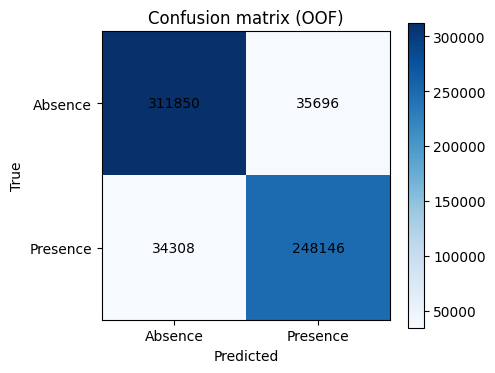

In [8]:
y_pred = (oof >= 0.5).astype(int)
cm = confusion_matrix(y, y_pred)
print("Confusion matrix (OOF, threshold=0.5)")
print("Rows: true, Cols: predicted |  Absence   Presence")
print(cm)
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks([0, 1], ["Absence", "Presence"])
plt.yticks([0, 1], ["Absence", "Presence"])
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.title("Confusion matrix (OOF)")
plt.tight_layout()
plt.show()

In [9]:
sub = pd.DataFrame({"id": test["id"], "Heart Disease": test_proba})
sub.to_csv(OUTPUT_DIR / "submission.csv", index=False)
print(f"Submission saved ({N_STACK_MODELS}-model blend): {OUTPUT_DIR / 'submission.csv'}")
sub.head(10)

Submission saved (4-model blend): submission.csv


,id,Heart Disease
id,,
630000,630000,0.958230
630001,630001,0.048153
630002,630002,0.967206
630003,630003,0.046752
630004,630004,0.167473
630005,630005,0.966365
630006,630006,0.045968
630007,630007,0.627969
630008,630008,0.967709
